In [1]:
#Method for calculating Markov transition matrix with nice steady state properties... minimise sq err
srand(1)
using JuMP, CPLEX



function Transition()
    rawData = round(readcsv("countryRowGrowth.csv"),2)

    global data = zeros(Int, 1,2)

    nCountries = size(rawData)[1]
    nYears = size(rawData)[2]

    minGrid = .85
    maxGrid = 1.14
    increment = .01
    
    global nStates = length(minGrid:increment:maxGrid)

    
    function valueToIndex(value)

        global index = convert(Int, round((value - minGrid)/increment + 1,0))

    end

    global vGrowthGrid = collect(minGrid:increment:maxGrid)
    global nGrowthGrid = length(vGrowthGrid)

    growthMat = zeros(nCountries, nYears)

    for m = 1:nCountries
        for n = 1:nYears
            if rawData[m,n] < 1000000
                growthMat[m,n] = vGrowthGrid[indmin(abs(vGrowthGrid .- rawData[m,n]))]
            end
        end
    end

    markov = zeros(nGrowthGrid,nGrowthGrid)



    for i = 1:nCountries
        for j = 1:nYears-1
            if rawData[i,j] < 1000000
                if rawData[i,j+1] < 1000000

                    x = convert(Int64,valueToIndex(growthMat[i,j]))
                    y = convert(Int64,valueToIndex(growthMat[i,j+1]))
                    
                    data= vcat(data, [valueToIndex(growthMat[i,j]), valueToIndex(growthMat[i,j+1])]')

                    markov[x,y] +=1
                end
            end

        end
    end

    for k = 1:nGrowthGrid
        markov[k,:] = markov[k,:]./sum(markov[k,:])
    end


    global mTransition = markov
    global data = data[2:end,:]
    global nData = length(data[2:end,1])
    global tallyState = hist(data[:,1], 1-.5:1:nStates+.5)[2]
    global s = tallyState/sum(tallyState)
end
Transition()
#mTransition is what we're shooting for
#vGrowthGrid is "rates" in the exstimation code



nStates = length(s)

states = collect(1:length(vGrowthGrid))




M = length(vGrowthGrid)
N = length(vGrowthGrid)

ONE = ones(M)

m = Model(solver = CplexSolver())

@variable(m, 0 <= T[1:M,1:N] <= 1)

@variable(m, topObj)



one = ones(M)
i = 1:M



@constraint(m, T'*s .== s)

@constraint(m, T*ONE .== ONE)

#@constraint(m, T .<= ones(M,M))
#@constraint(m, T .>= zeros(M,M))


@constraintref constraintFOSD[1:M]
for i = 1:M-1
    j = 1:M
    #constraintFOSD[i] = @constraint(m, sum(T[i,j]*rates[j]) <= sum(T[i+1,j]*rates[j]))
end

@constraint(m, T[1:M-1,:]*vGrowthGrid .<= T[2:M,:]*vGrowthGrid)

topObjVal = 0
#for a = 1:nData
    #topObjVal += @expression(m, ref, T[data[a,1], data[a,2]] - log(1+e.^T[data[a,1], data[a,2]]))
#    topObjVal += @expression(m,ref, T[data[a,1], data[a,2]] - )
#end

#what we shoot for
empDist = zeros(M,M)
for i = 1:nData

    x = convert(Int, data[i,1])
    y = convert(Int, data[i,2])

    if M >= x >= 1
        if M >= y >= 1
            empDist[x,y] +=1
        end
    end
end



for a = 1:nData
    topObjVal += @expression(m, ref, (T[states[data[a,1]], states[data[a,2]]] - 1)^2)
    
    for b in setdiff(states,data[a,2])
            topObjVal += @expression(m, ref, (T[states[data[a,1]], b])^2)
    end
end

@constraint(m, topObj == topObjVal)


@objective(m, Min, topObj) 
solve(m)
#getdual(T)
#print(m)
mTransition = getvalue(T)


 in depwarn(::String, ::Symbol) at .\deprecated.jl:64
 in #hist!#1016(::Bool, ::Function, ::Array{Int64,1}, ::Array{Int64,1}, ::FloatRange{Float64}) at .\deprecated.jl:630
 in hist(::Array{Int64,1}, ::FloatRange{Float64}) at .\deprecated.jl:645
 in Transition() at .\In[1]:70
 in include_string(::String, ::String) at .\loading.jl:441
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at C:\Users\Ryan\.julia\v0.5\IJulia\src\execute_request.jl:157
 in eventloop(::ZMQ.Socket) at C:\Users\Ryan\.julia\v0.5\IJulia\src\eventloop.jl:8
 in (::IJulia.##13#19)() at .\task.jl:360
while loading In[1], in expression starting on line 73


Tried aggregator 1 time.
QP Presolve eliminated 2 rows and 58 columns.
Reduced QP has 87 rows, 844 columns, and 3260 nonzeros.
Reduced QP objective Q matrix has 784 nonzeros.
Presolve time = 0.00 sec. (0.56 ticks)
Parallel mode: using up to 4 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1682
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.08 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 4
  Rows in Factor            = 87
  Integer space required    = 178
  Total non-zeros in factor = 2612
  Total FP ops to factor    = 95432
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0  5.7455460e+006 -5.7877100e+006 1.10e+004 1.60e+004 1.16e+006
   1  2.2056116e+003 -2.5825005e+003 8.25e+001 1.21e+002 8.71e+003
   2  1.8528609e+003  6.5700413e+002 2.10e+001 3.07e+001 2.21e+003
   3  1.8277477e+003  1.5562042e+003 4.84e+000 7.07e+000 5.10e+002
   4  1.8254712e+003  1.7685

30×30 Array{Float64,2}:
 0.0338322    0.0318305    0.0        …  0.0431384    0.135172   
 0.155915     8.94505e-12  0.0           0.0305653    0.0390563  
 0.0251551    0.0255734    0.0260029     0.0434505    0.0445202  
 3.4778e-11   3.84038e-11  0.0           0.0124115    0.0195209  
 0.0250421    0.0254775    0.0259237     0.0432993    0.0443096  
 0.0175908    0.0163316    0.0        …  3.85115e-11  3.85216e-11
 0.0152998    0.0146633    0.0           3.50888e-11  0.174414   
 0.0507063    0.0465056    0.0           8.22479e-12  7.68499e-12
 2.50094e-12  2.78496e-12  0.0           0.0310284    0.0385642  
 0.0185405    0.017833     0.0           9.43919e-12  1.02381e-11
 0.0672403    3.21932e-11  0.0        …  0.00292555   0.00731328 
 0.0233698    0.0247475    0.0           0.0363902    0.0086363  
 1.40214e-10  1.22915e-9   0.0           0.000230763  0.00433256 
 ⋮                                    ⋱                          
 0.011314     1.26582e-10  0.0           0.000409089

In [4]:
using PyPlot, StatsBase


    ##  1. Calibration
    r0 = .04#.03#
    
    #bbeta  = 1/(1+r0)    # Discount factor
    eta = 0#1#
    

    sigma = 2.1#1.5#
    gamma = .204
    t = .25#.4#
    phi =.62#.95#
    vGridU = sort(collect(19.6:1:19.6), rev = true)
    nGridU = length(vGridU)
    vSqErr = zeros(nGridU)
    bbar = 1.7#2.1#
    nGridProductivitySample = M
    due = 1#3#
    # Productivity values
    

    
    riData = readcsv("IntDebtGreece.csv")#readcsv("IntDebtEuro.csv")#
    empDistBonds =  riData[:,2]./100
    
    empDistGDP = vGrowthGrid
global vGridProductivity = t*vGrowthGrid#t*sort(vcat(sample(empDistGDP, nGridProductivitySample, replace=false, ordered=true),.7:.01:1))#
    
    lenData = size(empDistBonds)[1]
    Err = zeros(lenData)
    sqErr = zeros(lenData)
    global nGridProductivity = length(vGridProductivity)

    # Transition matrix


    # We generate the grid of bonds
    global vGridBonds = sort(vcat(empDistBonds,collect(.01:.01:bbar)))#sort(vcat(.01:.02:bbar, empDistBonds))
    global nGridBonds = length(vGridBonds)
    

    #convert(UInt64, nGridRenegot)
    
    findU = zeros(nGridBonds,nGridU)
    vGridABar = 1:nGridBonds
    global riAbar = ones(Int, nGridBonds, nGridU) #this is the index of the "reservation default at level of bond holdings
    bbeta = ones(nGridBonds)
    
    newriAbar = ones(Int, nGridBonds, nGridU)
    global ri = zeros(nGridBonds, nGridProductivity, nGridU)
    repayTot = zeros(nGridBonds,nGridProductivity)
    vec = zeros(due,nGridBonds)
    
    
    function restructure(bonds)
        differenceSq = zeros(nGridBonds)
        for currentDebt = 1:nGridBonds
            differenceSq[currentDebt] = abs(vGridBonds[currentDebt] - phi*vGridBonds[bonds])
        end
        global renegotIndex = findmin(differenceSq)[2]
        global renegotValue = findmin(differenceSq)[1]
    end 

    restructure(nGridBonds)
    maxRenegot = renegotValue
    nGridRenegot = renegotIndex
    
    # 3. Required matrices and vectors

    #mOutput           = zeros(nGridCapital,nGridProductivity)
    mValueFunction    = zeros(nGridBonds,nGridProductivity)
    VD = ones(nGridRenegot, nGridProductivity)
    
    #store results for each U
    global VSU = zeros(nGridBonds, nGridProductivity, nGridU)
    global VDU = zeros(nGridRenegot, nGridProductivity, nGridU)
    global PolicyU = zeros(nGridBonds,nGridProductivity,nGridU)
    global PolicyUIndex = zeros(Int, nGridBonds,nGridProductivity,nGridU)
    global tauU = zeros(nGridBonds, nGridProductivity, nGridU)
    
    mValueFunctionNew = zeros(nGridBonds,nGridProductivity)
    mPolicyFunction   = zeros(nGridBonds,nGridProductivity)
    global mPolicyFunctionIndex = zeros(Int, nGridBonds,nGridProductivity)
    expectedValueFunction = zeros(nGridBonds,nGridProductivity)
    
    global tau = zeros(nGridBonds, nGridProductivity, nGridU)
    global mDefault = zeros(nGridBonds, nGridProductivity,nGridU)

function main(theta)
    
    omega = theta


    

    
    riData = readcsv("IntDebtGreece.csv")#readcsv("IntDebtEuro.csv")#
    empDistBonds =  riData[:,2]./100
    
    empDistGDP = vGrowthGrid
    global vGridProductivity = t*sort(sample(empDistGDP, nGridProductivitySample, replace=false, ordered=true))#t*sort(vcat(sample(empDistGDP, nGridProductivitySample, replace=false, ordered=true),.7:.01:1))#
    
    lenData = size(empDistBonds)[1]
    Err = zeros(lenData)
    sqErr = zeros(lenData)
    global nGridProductivity = length(vGridProductivity)

    # Transition matrix


    # We generate the grid of bonds
    global vGridBonds = sort(vcat(empDistBonds,collect(.01:.01:bbar)))#sort(vcat(.01:.02:bbar, empDistBonds))
    global nGridBonds = length(vGridBonds)
    

    #convert(UInt64, nGridRenegot)
    
    findU = zeros(nGridBonds,nGridU)
    vGridABar = 1:nGridBonds
    global riAbar = ones(Int, nGridBonds, nGridU) #this is the index of the "reservation default at level of bond holdings
    bbeta = ones(nGridBonds)
    
    newriAbar = ones(Int, nGridBonds, nGridU)
    global ri = zeros(nGridBonds, nGridProductivity, nGridU)
    repayTot = zeros(nGridBonds,nGridProductivity)
    vec = zeros(due,nGridBonds)
    
    global nGridPrductivity = length(vGridProductivity)
    
    function restructure(bonds)
        differenceSq = zeros(nGridBonds)
        for currentDebt = 1:nGridBonds
            differenceSq[currentDebt] = abs(vGridBonds[currentDebt] - phi*vGridBonds[bonds])
        end
        global renegotIndex = findmin(differenceSq)[2]
        global renegotValue = findmin(differenceSq)[1]
    end 

    restructure(nGridBonds)
    maxRenegot = renegotValue
    nGridRenegot = renegotIndex
    
    # 3. Required matrices and vectors

    #mOutput           = zeros(nGridCapital,nGridProductivity)
    mValueFunction    = zeros(nGridBonds,nGridProductivity)
    VD = ones(nGridRenegot, nGridProductivity)
    
    #store results for each U
    global VSU = zeros(nGridBonds, nGridProductivity, nGridU)
    global VDU = zeros(nGridRenegot, nGridProductivity, nGridU)
    global PolicyU = zeros(nGridBonds,nGridProductivity,nGridU)
    global PolicyUIndex = zeros(Int, nGridBonds,nGridProductivity,nGridU)
    global tauU = zeros(nGridBonds, nGridProductivity, nGridU)
    
    mValueFunctionNew = zeros(nGridBonds,nGridProductivity)
    mPolicyFunction   = zeros(nGridBonds,nGridProductivity)
    global mPolicyFunctionIndex = zeros(Int, nGridBonds,nGridProductivity)
    expectedValueFunction = zeros(nGridBonds,nGridProductivity)
    
    global tau = zeros(nGridBonds, nGridProductivity, nGridU)
    global mDefault = zeros(nGridBonds, nGridProductivity,nGridU)



   
    # 4. We pre-build output for each point in the grid

    #mOutput = (vGridCapital.^aalpha)*vGridProductivity;

    # 5. Main iteration
    UIndex = 0
    for UIndex = 1:nGridU 
        ubar = vGridU[UIndex]
        riDiff = 1
        ValueHighSoFar = -100000
        
        #not good
        #riAbar[:,UIndex] = ones(nGridBonds)
        #newriAbar[:,UIndex] = ones(nGridBonds)
        
        mValueFunctionNew = zeros(nGridBonds,nGridProductivity)
        mPolicyFunction   = zeros(nGridBonds,nGridProductivity)
        global mPolicyFunctionIndex = zeros(Int, nGridBonds,nGridProductivity)
        expectedValueFunction = zeros(nGridBonds,nGridProductivity)
        
        mValueFunction    = zeros(nGridBonds,nGridProductivity)
        VD = ones(nGridRenegot, nGridProductivity)
        
        while riDiff > 0 
            maxDifference = 10.0
            tolerance = .001
            iteration = 0
            
            a = 0
            for a = 1:nGridBonds
                for b = 1:nGridProductivity
                    ri[a, b, UIndex] = ((1+r0 - phi*(1-omega)*sum(mTransition[b,1: riAbar[a, UIndex]]))/
                    (1 - (1-omega)*sum(mTransition[b,1: riAbar[a, UIndex]])) - 1)
                    #(1+r0)/(1 - (riAbar[a]-1)*(1 - omega)/nGridProductivity)-1
                    for i = 1:due
                        vec[i,:] = (1/due) ./((1+ri[a,b, UIndex]).^i)
                    end
                
                
                repayTot[a,b] = 1 ./sum(vec[:,a])
                
                bbeta[a] = (1 - eta*(1-omega)*sum(mTransition[b,1: riAbar[a, UIndex]]))/(1 + r0)
                end
            end
            


            while(maxDifference > tolerance)
                defprod = 0
                
                
                
                expectedValueFunction = mValueFunction*mTransition'.*(vGridProductivity'.*(1/t)).^(1-sigma);
                global expectedVD = VD*mTransition'.*(vGridProductivity'.*(1/t)).^(1-sigma)
                expectedProductivity = vGridProductivity'*mTransition
                bondsChoice  = copy(vGridBonds[1])
                bondsChoiceIndex = 1
                
                for count = 1:50
                    expectedVD = VD*mTransition'.*(vGridProductivity'.*(1/t)).^(1-sigma)
                    for renegotiatedDebt = 1:nGridRenegot
                        for defprod =  1:nGridProductivity # all default productivity levels... could actually reduce nGridProd to the highest level where default happens
                            defspend = t#vGridProductivity[defprod]::Float64
                            nextDebtIndex = findmin([nGridRenegot, findmin(
                                abs(vGridBonds - phi.*vGridBonds[renegotiatedDebt]./((1/t).*vGridProductivity[defprod])))[2]])[1]


                            VD[renegotiatedDebt,defprod] = ((defspend^(1 - sigma))/(1 - sigma) + bbeta[nGridBonds] * 
                            gamma * expectedValueFunction[nextDebtIndex,defprod] +
                            bbeta[nGridBonds]*(1 - gamma)*expectedVD[nextDebtIndex, defprod])
                        end
                    count = count+1
                    
                    end
                end
                
                expectedVD = VD*mTransition'.*(vGridProductivity'.*(1/t)).^(1-sigma)
                nProductivityToday = 0
                for nProductivityToday = 1:nGridProductivity
                    nBondsToday = 0
                    for nBondsToday = 1:nGridBonds
                        
                        renegotIndex = findmin([nGridRenegot, findmin(
                            abs(vGridBonds - phi.*vGridBonds[nBondsToday]./((1/t).*vGridProductivity[nProductivityToday])))[2]])[1]
                        #restructure(nBondsToday./(nProductivityToday.*(1./t)))
                        valueHighSoFar = -100000000000
                        nBondsNextPeriod = 0
                        for nBondsNextPeriod = 1:nGridBonds #can I vectorize this part?
                                
                            if nProductivityToday > riAbar[nBondsToday, UIndex] - 1
                                
                                #TodTomDebtDiff = vGridProductivity[nProductivityToday]*vGridBonds[nBondsNextPeriod]/t - ((due - 1)/due)vGridBonds[nBondsToday]
                                
                                
                                #leftForCons = TodTomDebtDiff/(repayTot[nBondsNextPeriod,nProductivityToday])
                                
                                
                                govspend = (t + (1/t)vGridProductivity[nProductivityToday].*
                                vGridBonds[nBondsNextPeriod]/(1 + ri[nBondsNextPeriod, nProductivityToday, UIndex]) -
                                vGridBonds[nBondsToday])
                                #vGridProductivity[nProductivityToday] - (1/due)*vGridBonds[nBondsToday] + leftForCons
                               

                                if govspend>0
                                    valueProvisional = ((govspend^(1 - sigma)) /(1 - sigma)
                                    + bbeta[nBondsNextPeriod]*expectedValueFunction[nBondsNextPeriod,nProductivityToday])
                                else  
                                    valueProvisional = (((t).^(1 - sigma))./(1 - sigma) +
                                    bbeta[nGridBonds].*expectedVD[renegotIndex, nProductivityToday] - ubar) 
                                    bondsChoiceIndex = renegotIndex
                                    bondsChoice = vGridBonds[renegotIndex]
                                end

                                if valueProvisional > valueHighSoFar

                                    valueHighSoFar = copy(valueProvisional)
                                    bondsChoice = copy(vGridBonds[nBondsNextPeriod])
                                    bondsChoiceIndex = copy(nBondsNextPeriod)
                                end
                            else
                                valueHighSoFar = (((t).^(1 - sigma))./(1 - sigma) +
                                bbeta[nGridBonds].*expectedVD[renegotIndex, nProductivityToday] - ubar) 
                                bondsChoice = vGridBonds[renegotIndex] # this isn't true if saved by IMF, need to calc new bond holdings
                                bondsChoiceIndex = renegotIndex
                            end
                        end
                        mValueFunctionNew[nBondsToday,nProductivityToday] = copy(valueHighSoFar)
                        mPolicyFunction[nBondsToday,nProductivityToday] = copy(bondsChoice)
                        mPolicyFunctionIndex[nBondsToday,nProductivityToday] = copy(bondsChoiceIndex)
                        
                    end
                end

                
                
                maxDifference  = maximum(abs(mValueFunctionNew - mValueFunction))
                #println(mValueFunctionNew-mValueFunction)
                mValueFunction    = copy(mValueFunctionNew)
                iteration = iteration+1
                mValueFunctionNew = zeros(nGridBonds, nGridProductivity)




            end

            risk = 0
            riDiff = 0
            for risk = 1:nGridBonds #risk is index of bonds today
                restructure(risk)
                expectedValueFunction = mValueFunction*mTransition'.*(vGridProductivity'.*(1/t)).^(1-sigma)
                expectedVD = VD*mTransition'.*(vGridProductivity'.*(1/t)).^(1-sigma)
                if riAbar[risk, UIndex] < nGridProductivity 
                    
            
                    
                    spend = (t + (1/t)*vGridProductivity[riAbar[risk]].*vGridBonds[mPolicyFunctionIndex[risk,riAbar[risk]]]./
                    (1 + ri[mPolicyFunctionIndex[risk,riAbar[risk]], UIndex]) - vGridBonds[risk])

                    
                    
                    
                    #spend = (vGridProductivity[riAbar[risk]] - vGridBonds[risk] + mPolicyFunction[risk,riAbar[risk]]./(1+
                    #ri[mPolicyFunctionIndex[risk,riAbar[risk]]]))
                    
                    #expConTomSol = vGridProductivity - vGridBonds[risk] + mPolicyFunction'[risk,:]./(ri[mPolicyFunction'[risk,:]])
                    #expConTomDef = vGridProductivity
                    if spend >0
                        forcedSol = ((spend[1]^(1 - sigma))./(1 - sigma) + bbeta[risk]*
                        expectedValueFunction[mPolicyFunctionIndex[risk, riAbar[risk, UIndex]], riAbar[risk, UIndex]] )
                    else
                        forcedSol = -100000000
                    end
                    
                    nextDebtIndex = findmin([nGridRenegot, findmin(
                        abs(vGridBonds - phi.*vGridBonds[risk]./((1/t).*vGridProductivity[riAbar[risk, UIndex]])))[2]])[1]
                    forcedDef = (((t)^(1 - sigma))/(1 - sigma) +
                    bbeta[nGridBonds]*expectedVD[nextDebtIndex, riAbar[risk, UIndex]]) - ubar

                    if forcedSol[1] <= forcedDef[1]
                        #newriAbar[risk:nGridBonds] = min(riAbar[risk:nGridBonds] + ones(nGridBonds - risk + 1),nGridProductivity*ones(nGridBonds 
                        #- risk + 1))
                        newriAbar[risk, UIndex] = min(newriAbar[risk, UIndex] + 1, nGridBonds)
                        if risk>1
                            for increase =  risk:nGridBonds-1
                                if  newriAbar[increase, UIndex] > newriAbar[increase + 1, UIndex]
                                    newriAbar[increase + 1, UIndex:nGridU] += 1
                                end
                            end
                        end
                        #if risk > 1
                        #    newriAbar = vcat(riAbar[1:(risk - 1)], min(min(riAbar[risk:nGridBonds] + 1,ones(nGridBonds - risk + 1)*nGridProductivity),
                        #    ones

                        #else
                        #    newriAbar = min(riAbar + 1,nGridProductivity)
                        #end

                    else
                        newriAbar[risk, UIndex:nGridU] = copy(riAbar[risk, UIndex])
                    end
                    
                else
                    newriAbar[risk, UIndex:nGridU] = nGridProductivity
                    
                    #riDiff = 0
                    #break #cannot raise the cuttoff any higher
                end
                riDiff = abs(sum(newriAbar - riAbar)) + riDiff
                riAbar = copy(newriAbar)
            end
            #newriAbar = ones(nGridBonds)

        end    
        
        m = 1
        n = 1
        
        for m = 1:nGridBonds
            for n = 1:nGridProductivity
                if riAbar[m, UIndex] > n
                    mDefault[m,n,UIndex] = 1
                end
            end
        end
        #find level of bonds s.t no default ever happens maxSolBonds
        maxSolBonds = zeros(nGridProductivity)
        x = 1
        y = 1
        for x = 1:nGridProductivity
            for y = 1:nGridBonds
                restructure(y)
                if x >= riAbar[y, UIndex]
                    maxSolBonds[x] = y
                else
                    maxSolBonds[x] = renegotIndex
                end

            end
        end
        p = 1
        q = 1


        #place ri results into matrix
            findU[:, UIndex] = ri[:,1, UIndex] #need to find interest rates as function of gdp match in data!
        dataInd = 0
        for dataInd = 1:lenData
            dataIndInComp= find(vGridBonds.==empDistBonds[dataInd])[1]
            Err[dataInd] = ri[dataIndInComp[1],nGridProductivity, UIndex] - riData[dataInd,1]./100
        end
        
        VSU[:,:,UIndex] = mValueFunction
        VDU[:,:,UIndex] = VD - ubar
        PolicyU[:,:,UIndex] = mPolicyFunction
        PolicyUIndex[:,:,UIndex] = mPolicyFunctionIndex
        tauU[:,:,UIndex] = tau[:,:,UIndex]
        
        sqErr = Err'*Err
 
        vSqErr[UIndex] = sqErr[1]

    end
    

    global vSqErr = -vSqErr'
    
    #Steady State Bonds Distribution

    global optimalUIndex = findmax(vSqErr)[2]
    global uii = vGridU[optimalUIndex]
    global bondsTodayToTomorrowProb = zeros(nGridBonds,nGridBonds)
    
    ssTransition = mTransition^10000
    
    global muBondsProd = zeros(nGridProductivity*nGridBonds, nGridProductivity*nGridBonds)

    
    for bToday = 1:nGridBonds
        for gToday = 1:nGridProductivity
            for bTom = 1:nGridBonds
                for gTom = 1:nGridProductivity
                    if PolicyUIndex[bToday,gToday] == bTom
        #row of bonds to bonds matrix is the tally function, check to be sure that prime is working
                        muBondsProd[(nGridProductivity)*(bToday-1) + gToday, (nGridProductivity)*(bTom-1) + gTom] += mTransition[gToday,gTom]
                    end
                end
            end
        end
    end
    
end

main (generic function with 1 method)

(Any) in module Main at In[2]:58 overwritten at In[4]:58.


In [5]:
using PyPlot

function findBond(bonds)
    differenceSq = zeros(nGridBonds)
    for currentDebt = 1:nGridBonds
        differenceSq[currentDebt] = abs(vGridBonds[currentDebt] - bonds)
    end
    global findBondIndex = findmin(differenceSq)[2]
    global findBondGrow = findmin(differenceSq)[1]
end 

    global vGridBonds = sort(vcat(empDistBonds,collect(.01:.01:bbar)))#sort(vcat(.01:.02:bbar, empDistBonds))
    global nGridBonds = length(vGridBonds)
    nBondProd = 5490

function calcPerDef(range)
    
    nBondProd = 5490
    
    #nGridBond = nGridBonds*nGridProductivity
    global omegaEpsilonGrid = range
    global nOEGrid = length(omegaEpsilonGrid)
    global perInDefault = zeros(nOEGrid)
    global perDefaultingThisYear = zeros(nOEGrid)

    global perThreatening = zeros(nOEGrid)
    global ssMuVec = zeros(nBondProd)
    #+epsilon, -epsilon, true

    global mValueS = zeros(nGridBonds,nGridProductivity, nOEGrid)
    global mValueD = zeros(nGridRenegot,nGridProductivity, nOEGrid)
    global storePolicy = zeros(nGridBonds,nGridProductivity, nOEGrid)
    global storeInt = zeros(nGridBonds,nGridProductivity, nOEGrid)
    
    
    global muBondsProdAdj = zeros(nBondProd,nBondProd)
    penaltyBoxAdj = zeros(nBondProd,nBondProd)
    global penaltyBoxShaker = zeros(nBondProd, nBondProd)
    
    global fixed = ones(nBondProd)/nBondProd
    freeNew = zeros(nBondProd)
    
    global free = zeros(nBondProd)
    fixedNew = zeros(nBondProd)
    
    global storeFree = zeros(nBondProd, nOEGrid)
    global storeFixed = zeros(nBondProd, nOEGrid)
    
    global storeDefault = zeros(nBondProd, nOEGrid)
    for omegaEpsilonIndex = 1:nOEGrid
        omegaEpsilon = omegaEpsilonGrid[omegaEpsilonIndex]
        main(omegaEpsilon)
        global mDefaultVec = reshape((mDefault[:,:,1])',1,nBondProd) #should probably be mDefault'
        mValueS[:,:,omegaEpsilonIndex] = VSU[:,:,optimalUIndex]
        mValueD[:,:,omegaEpsilonIndex] = VDU[:,:,optimalUIndex]
        storePolicy[:,:,omegaEpsilonIndex] = PolicyUIndex[:,:,optimalUIndex]
        storeInt[:,:,omegaEpsilonIndex] = ri

        nBondProd = length(muBondsProd[1,:])
        
        penaltyBoxShaker = zeros(nBondProd,nBondProd)
        

        A = zeros(nBondProd)
        for i = 1:nBondProd
            A[i] = sum(muBondsProd[i,:])
        end

        
        for j = 1:nBondProd

            muBondsProdAdj[j,:] = muBondsProd[j,:]/A[j]
        end
        
        
        #ssMu = muBondsProdAdj^10000

        #ssBondHoldings = zeros(nGridBonds)
        #for x = 1:nBondProd
        #    ssBondHoldings[fld(x-1,nGridProductivity)+1] = ssMu[1,x]
        #end

        



        diff1 = 10
        diff2 = 10
        count = 0
        iter1 = 0
        gamma = .21



        #free = muBondsProdAdj - penaltyBoxAdj
        
        while diff1 >= 10.0^-5
            
            for bToday = 1:nGridBonds
                for gToday = 1:nGridProductivity
                    for gTom = 1:nGridProductivity
                        
                        bTom = bToday #findBondIndex
                        penaltyBoxShaker[(nGridProductivity)*(bToday-1) + gToday, (nGridProductivity)*(bTom - 1) + gTom] += (
                        fixed[(nGridProductivity)*(bToday-1) + gToday]*mTransition[gToday, gTom])
            
                    end
                end
            end
            
            fixedNew = ((1 - gamma).*ones(nBondProd)'*penaltyBoxShaker + (1 - omegaEpsilon).*free'.*mDefaultVec*muBondsProdAdj)'
            ######something wrong here
            freeNew = (omegaEpsilon.*free'.*mDefaultVec*muBondsProdAdj  + free'.*(1 - mDefaultVec)*muBondsProdAdj
            + (gamma).*ones(nBondProd)'*penaltyBoxShaker)'
            
            
            diff1 = sum(abs(freeNew - free))
            
            free = copy(freeNew)
            fixed = copy(fixedNew)
            
            iter1 +=1
            

            
            if iter1 >2000
                break
            end
            
            if sum(free+fixed) <=.9999
                println("low = ", iter1, " total Free = ", sum(free), " total fixed = ", sum(fixed) )
                break
            end
            
            if sum(free + fixed) >= 1.001
                println("high = ", iter1, " total Free = ", sum(free), " total fixed = ", sum(fixed) )
                break
            end
            
            freeNew = zeros(nBondProd)
            fixedNew = zeros(nBondProd)
            penaltyBoxShaker = zeros(nBondProd,nBondProd)
            
        end
        
        perThreatening[omegaEpsilonIndex] = sum(free'*mDefaultVec')
        perDefaultingThisYear[omegaEpsilonIndex] = (1 - omegaEpsilon)sum(free'*mDefaultVec')
                
        storeFree[:,omegaEpsilonIndex] = free
        storeFixed[:,omegaEpsilonIndex] = fixed
        storeDefault[:,omegaEpsilonIndex] = mDefaultVec
#        while diff2 >10^-5     
                
#            stainNew = (1-gamma)*stain + ((1 - omegaEpsilon) .* mDefaultVec * ssMu[1,:]).*sol
#            solNew = gamma*stain + (1 - (1 - omegaEpsilon) .* mDefaultVec * ssMu[1,:]).*sol
#
#            diff = sum(abs(solNew - sol))
#            stain = stainNew
#            sol = solNew

#            solNew = 0
#            stainNew = 0

#            count += 1
#            if count>=500
#               break
#            end
#        end
        
        #perInDefault[omegaEpsilonIndex] = stain[1]
        println("Theta = ", omegaEpsilonGrid[omegaEpsilonIndex], 
        #", Stained = ",  round(stain[1],4), 
        ", Threatening = ", round(perThreatening[omegaEpsilonIndex],4),
        ", Defaulting = ", round(perDefaultingThisYear[omegaEpsilonIndex], 4))
    end
end

tic()
OERange = collect(.68:.01:.72)#collect(.6:.005:.8)
calcPerDef(OERange)
toc()

mValueSVec = zeros(nBondProd,nOEGrid)
mValueDVec = zeros(nBondProd,nOEGrid)

for i = 1:nOEGrid
    mValueSVec[:, i] = reshape(mValueS[:, :, i]', 1, nBondProd)
    
    for bToday = 1:nGridRenegot
        for gToday = 1:nGridProductivity
            mValueDVec[(nGridProductivity)*(bToday-1) + gToday, nOEGrid] = mValueD[bToday,gToday,i]
        end
    end
    
end


value = zeros(nOEGrid)
penalty = zeros(nOEGrid)
endowment = zeros(nOEGrid)
endowmentCost = zeros(nOEGrid)

for i = 1:nOEGrid
    value[i] =  (mValueSVec[:,i]'*storeFree[:,i] + mValueDVec[:,i]'*storeFixed[:,i])[1]
    penalty[i] =  (storeFree[:,i]'*storeDefault[:,i])[1]

    for bToday = 1:nGridBonds
        for gToday = 1:nGridProductivity
            endowment[i] += 
            storeFree[(nGridProductivity)*(bToday-1) + gToday,i]*storeDefault[(nGridProductivity)*(bToday-1) + gToday,i].*vGridBonds[bToday]
        end
    end
end

for i = 1:nOEGrid
    value[i] =  (mValueSVec[:,i]'*storeFree[:,i] + mValueDVec[:,i]'*storeFixed[:,i])[1]
    penalty[i] =  (storeFree[:,i]'*storeDefault[:,i])[1]

    for bToday = 1:nGridBonds
        for gToday = 1:nGridProductivity
            endowmentCost[i] += (storeFree[(nGridProductivity)*(bToday-1) + gToday,i].*(( (vGridProductivity[gToday] - vGridBonds[bToday] +
            vGridBonds[PolicyUIndex[bToday,gToday]]*vGridProductivity[gToday]*4./storeInt[bToday,gToday, i]
            ).^
            (1-sigma))./(1-sigma) -
            ((vGridProductivity[gToday] - vGridBonds[bToday] +
            vGridBonds[PolicyUIndex[bToday,gToday]]*vGridProductivity[gToday]*4/storeInt[bToday,gToday, i] - endowment[i]).^
            (1-sigma))./(1-sigma)))
        end
    end
end

Theta = 0.68, Threatening = 0.0092, Defaulting = 0.0029


Theta = 0.69, Threatening = 0.0092, Defaulting = 0.0029
Theta = 0.7, Threatening = 0.0093, Defaulting = 0.0028
Theta = 0.71, Threatening = 0.0092, Defaulting = 0.0027
Theta = 0.72, Threatening = 0.0093, Defaulting = 0.0026
elapsed time: 7115.850493953 seconds


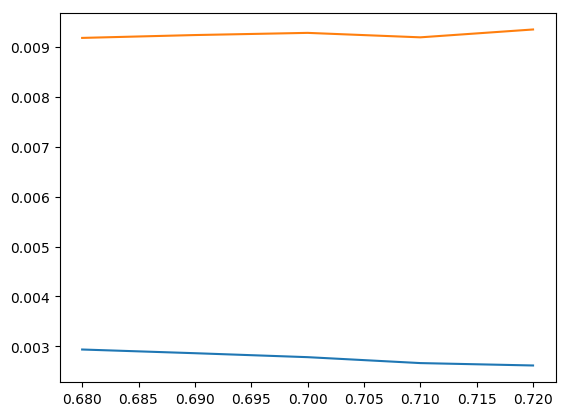

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000025481BA8>

In [6]:
plot(omegaEpsilonGrid, perDefaultingThisYear, label = "% Defaulting")
plot(omegaEpsilonGrid, perThreatening, label = "% Threatening")

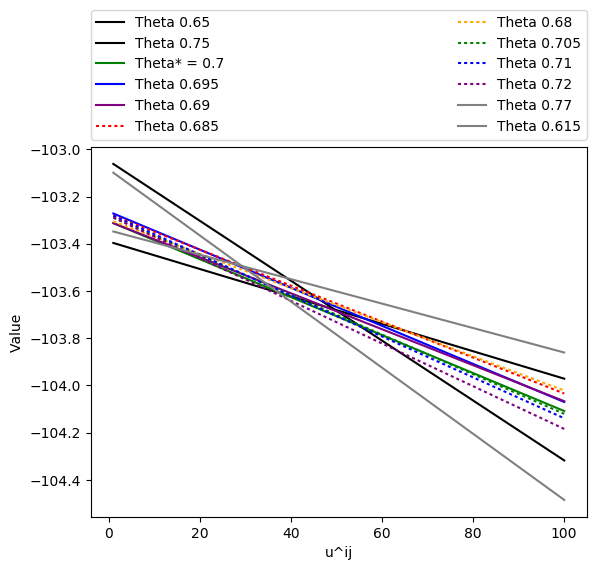

PyObject <matplotlib.text.Text object at 0x000000029C2F8B38>

In [337]:
-
ylabel("Value")

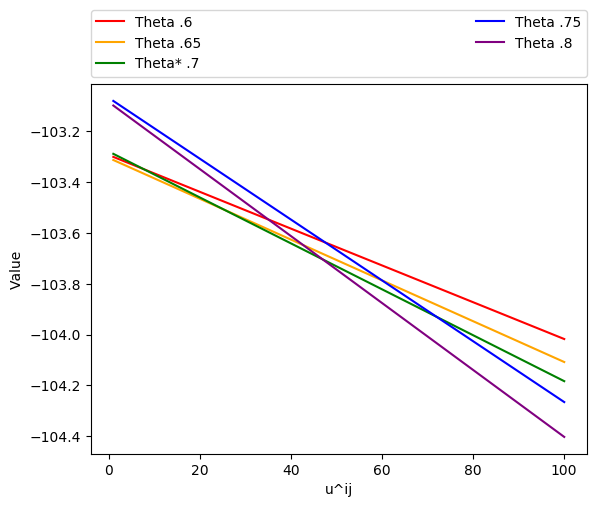

PyObject <matplotlib.text.Text object at 0x000000002C484208>

In [240]:
plot((1:100), (value[1,:]-penalty[1,:] - endowment[1,:]), color = "red", label = "Theta .6")
plot((1:100), (value[2,:]-penalty[2,:] - endowment[2,:]), color = "orange", label = "Theta .65")
plot((1:100), (value[3,:]-penalty[3,:] - endowment[3,:]), color = "green", label = "Theta* .7")
plot((1:100), (value[4,:]-penalty[4,:] - endowment[4,:]), color = "blue", label = "Theta .75")
plot((1:100), (value[5,:]-penalty[5,:] - endowment[5,:]), color = "purple",  label = "Theta .8")

legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=2, mode="expand", borderaxespad=0.)
xlabel("u^ij")
ylabel("Value")

In [213]:
using Interpolations
#interpolate(perDefaultingThisYear[:,1])
A = hcat(OERange, perDefaultingThisYear)
A = convert(AbstractArray, A)
interpolate(A[:,2])

LoadError: MethodError: no method matching interpolate(::Array{Float64,1})[0m
Closest candidates are:
  interpolate{IT<:Union{Interpolations.BSpline{D<:Interpolations.Degree},Interpolations.NoInterp,Tuple{Vararg{Union{Interpolations.BSpline,Interpolations.NoInterp},N}}},GT<:Union{Interpolations.GridType,Interpolations.NoInterp,Tuple{Vararg{Union{Interpolations.GridType,Interpolations.NoInterp},N}}}}(::AbstractArray{T,N}, [1m[31m::IT<:Union{Interpolations.BSpline{D<:Interpolations.Degree},Interpolations.NoInterp,Tuple{Vararg{Union{Interpolations.BSpline,Interpolations.NoInterp},N}}}[0m, [1m[31m::GT<:Union{Interpolations.GridType,Interpolations.NoInterp,Tuple{Vararg{Union{Interpolations.GridType,Interpolations.NoInterp},N}}}[0m) at C:\Users\Ryan\.julia\v0.5\Interpolations\src\b-splines/b-splines.jl:57
  interpolate{TWeights,TC,IT<:Union{Interpolations.BSpline{D<:Interpolations.Degree},Interpolations.NoInterp,Tuple{Vararg{Union{Interpolations.BSpline,Interpolations.NoInterp},N}}},GT<:Union{Interpolations.GridType,Interpolations.NoInterp,Tuple{Vararg{Union{Interpolations.GridType,Interpolations.NoInterp},N}}}}([1m[31m::Type{TWeights}[0m, [1m[31m::Type{TC}[0m, [1m[31m::Any[0m, [1m[31m::IT<:Union{Interpolations.BSpline{D<:Interpolations.Degree},Interpolations.NoInterp,Tuple{Vararg{Union{Interpolations.BSpline,Interpolations.NoInterp},N}}}[0m, [1m[31m::GT<:Union{Interpolations.GridType,Interpolations.NoInterp,Tuple{Vararg{Union{Interpolations.GridType,Interpolations.NoInterp},N}}}[0m) at C:\Users\Ryan\.julia\v0.5\Interpolations\src\b-splines/b-splines.jl:53
  interpolate{TWeights,TCoefs,Tel,N,IT<:Union{Interpolations.Gridded{D<:Interpolations.Degree},Interpolations.NoInterp,Tuple{Vararg{Union{Interpolations.Gridded,Interpolations.NoInterp},N}}}}([1m[31m::Type{TWeights}[0m, [1m[31m::Type{TCoefs}[0m, [1m[31m::Tuple{Vararg{Union{AbstractArray{T,1},Tuple},N}}[0m, [1m[31m::AbstractArray{Tel,N}[0m, [1m[31m::IT<:Union{Interpolations.Gridded{D<:Interpolations.Degree},Interpolations.NoInterp,Tuple{Vararg{Union{Interpolations.Gridded,Interpolations.NoInterp},N}}}[0m) at C:\Users\Ryan\.julia\v0.5\Interpolations\src\gridded/gridded.jl:52
  ...[0m

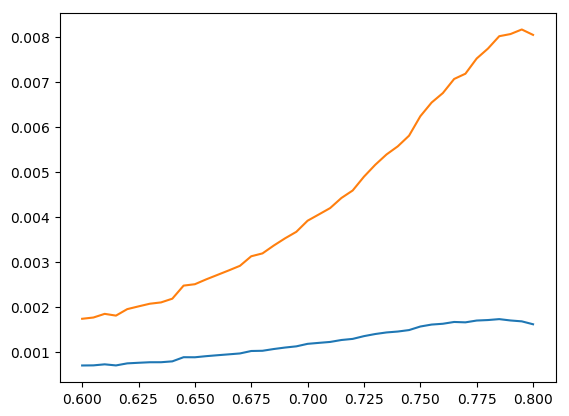

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000257EAB70>

In [4]:
plot(omegaEpsilonGrid, perDefaultingThisYear, label = "% Defaulting")
plot(omegaEpsilonGrid, perThreatening, label = "% Threatening")

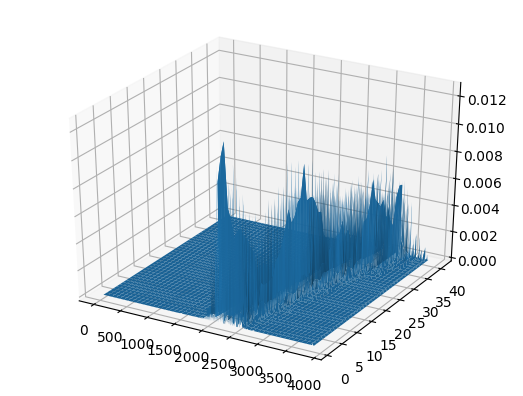

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x0000000057DD4A58>

In [286]:
surf(storeFree)

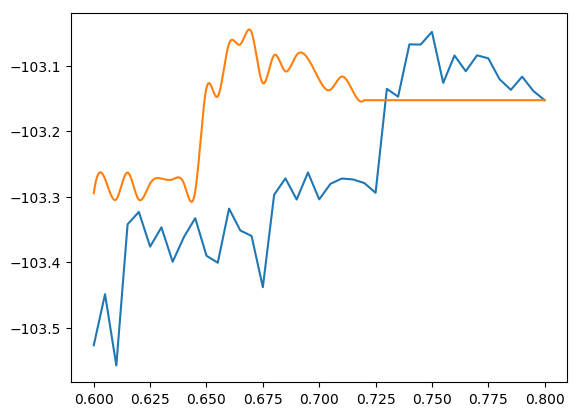

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000029D8E0CC0>

In [353]:
ValueStoInt = zeros(length(OERange))
for i = 1:length(OERange)
    ValueStoInt[i] = sum(storeFree[:,i]' * mValueSVec[:,i])
end
plot(OERange, ValueStoInt)

spl = Spline1D(OERange, ValueStoInt)

fine = collect(.6:.0001:.8)
nFine = length(fine)

graph = zeros(nFine)
for i = 1:nFine
    graph[i] = spl(.68+.0001*i)
end
plot(fine, graph)

In [357]:
using Grid
yi = InterpGrid(ValueStoInt, BCnil, InterpQuadratic)
println(yi)

[-103.527,-103.449,-103.558,-103.342,-103.323,-103.376,-103.347,-103.4,-103.362,-103.333,-103.39,-103.401,-103.318,-103.352,-103.36,-103.438,-103.297,-103.272,-103.304,-103.263,-103.304,-103.28,-103.272,-103.274,-103.279,-103.294,-103.136,-103.147,-103.068,-103.068,-103.049,-103.126,-103.085,-103.109,-103.084,-103.089,-103.121,-103.137,-103.117,-103.139,-103.153]


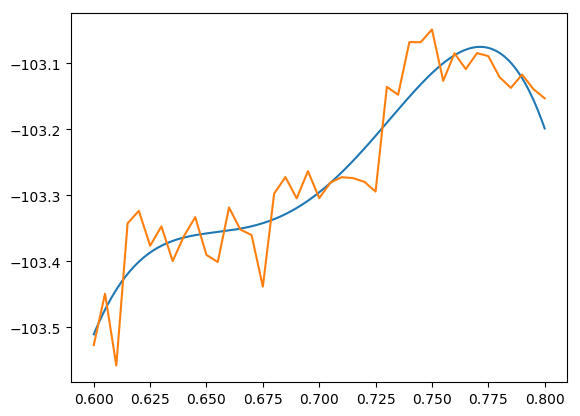

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000029E682208>

In [364]:
#steps 
#run to find how things change in theta
#print out vector, copy into excel, change to comma orientation
#import to stata, regress on some fitting exponent, look at the raw data to determine
#write function using coefficients
function smoothVS(OE)
    global value = 5201.533  * OE -11329.11 * OE.^2 + 10937.48 * OE.^3 -3947.635 * OE.^4 +  -996.833  
end

graph = zeros(length(.6:.001:.8))
index = 0
for i = .6:.001:.8
    index +=1
    OE = i
    smoothVS(i)
    graph[index] = value
end
plot(.6:.001:.8,graph)
plot(OERange, ValueStoInt)

In [243]:
penaltyBoxShaker = zeros(nBondProd,nBondProd)
for bToday = 1:nGridBonds
    for gToday = 1:nGridProductivity
        for gTom = 1:nGridProductivity

            findBond(bToday/(4*vGridProductivity[gToday]))
            bTom = findBondIndex

            penaltyBoxShaker[(nGridProductivity)*(bToday-1) + gToday, (nGridProductivity)*(bTom - 1) + gTom] += (
            fixed[(nGridProductivity)*(bToday-1) + gToday]*mTransition[gToday, gTom])

        end
    end
end
sum(penaltyBoxShaker)/sum(fixed)

1.000000000036014

In [3]:

value = zeros(nOEGrid)
penalty = zeros(nOEGrid)
endowment = zeros(nOEGrid)


for i = 1:nOEGrid
    value[i] =  (mValueSVec[:,i]'*storeFree[i] + mValueDVec[:,i]'*storeFixed[:,i])[1]
    penalty[i] =  (storeFree[:,i]'*storeDefault[:,i])[1]

    for bToday = 1:nGridBonds
        for gToday = 1:nGridProductivity
            endowment[i] += (storeFree[(nGridProductivity)*(bToday-1) + gToday,i].*(( (vGridProductivity[gToday] - vGridBonds[bToday] +
            vGridBonds[PolicyUIndex[bToday,gToday]]*vGridProductivity[gToday]*4 ./storeInt[bToday,gToday, i]
            ).^
            (1-sigma))./(1-sigma) ))#-
            #((vGridProductivity[gToday] - vGridBonds[bToday] +
            #vGridBonds[PolicyUIndex[bToday,gToday]]*vGridProductivity[gToday]*4/storeInt[bToday,gToday, i] -
            #storeFree[(nGridProductivity)*(bToday-1) + gToday,i]*storeDefault[(nGridProductivity)*(bToday-1) + gToday,i].*vGridBonds[bToday]).^
            #(1-sigma))./(1-sigma)))
        end
    end
end

LoadError: UndefVarError: nOEGrid not defined

In [29]:
bToday = nGridBonds
gToday = nGridProductivity

storeFree[(nGridProductivity)*(bToday-1) + gToday,i]

1

In [9]:
for bToday = 1:nGridBonds
    for gToday = 1:nGridProductivity
storeFree[(nGridProductivity)*(bToday-1) + gToday,i]*storeDefault[(nGridProductivity)*(bToday-1) + gToday,i]
    end
end
storeFree

3843×9 Array{Float64,2}:
 1.21367e-12  5.07918e-16  1.04802e-19  …  9.86101e-47  2.4386e-51 
 3.03417e-13  1.2698e-16   2.62005e-20     2.46525e-47  6.0965e-52 
 2.42734e-13  1.01584e-16  2.09604e-20     1.9722e-47   4.8772e-52 
 7.88884e-13  3.30147e-16  6.81212e-20     6.40966e-47  1.58509e-51
 7.28201e-13  3.04751e-16  6.28812e-20     5.91661e-47  1.46316e-51
 1.63845e-12  6.8569e-16   1.41483e-19  …  1.33124e-46  3.29211e-51
 1.88119e-12  7.87274e-16  1.62443e-19     1.52846e-46  3.77983e-51
 2.30597e-12  9.65045e-16  1.99124e-19     1.87359e-46  4.63334e-51
 3.82305e-12  1.59994e-15  3.30126e-19     3.10622e-46  7.68159e-51
 4.06579e-12  1.70153e-15  3.51086e-19     3.30344e-46  8.16931e-51
 5.70424e-12  2.38722e-15  4.92569e-19  …  4.63467e-46  1.14614e-50
 8.55636e-12  3.58082e-15  7.38854e-19     6.95201e-46  1.71921e-50
 1.26221e-11  5.28235e-15  1.08994e-18     1.02554e-45  2.53614e-50
 ⋮                                      ⋱                          
 4.06579e-12  1.70153e-

In [14]:
storeFree'*mDefaultVec'

9×1 Array{Float64,2}:
 5.18236e-11
 2.16881e-14
 4.47504e-18
 8.74265e-23
 2.59123e-28
 4.79318e-34
 1.42065e-39
 0.0040483  
 0.00786955 

In [18]:
for i = 1:nOEGrid


    for bToday = 1:nGridBonds
        for gToday = 1:nGridProductivity
            endowment[i] += (#storeFree[(nGridProductivity)*(bToday-1) + gToday,i].*(( (vGridProductivity[gToday] - vGridBonds[bToday] +
            #vGridBonds[PolicyUIndex[bToday,gToday]]*vGridProductivity[gToday]*4./storeInt[bToday,gToday, i]
            #).^
            #(1-sigma))./(1-sigma) )) -
            ((vGridProductivity[gToday] - vGridBonds[bToday] +
            vGridBonds[PolicyUIndex[bToday,gToday]]*vGridProductivity[gToday]*4/storeInt[bToday,gToday, i] -
            storeFree[(nGridProductivity)*(bToday-1) + gToday,i]*storeDefault[(nGridProductivity)*(bToday-1) + gToday,i].*vGridBonds[bToday]).^
            (1-sigma))./(1-sigma))
        end
    end
end
secondPart = endowment

9-element Array{Float64,1}:
  -623.34 
 26079.9  
 -8785.15 
 25002.2  
 -1105.91 
  -477.255
  -312.975
  -259.309
  -250.668

In [41]:
endowment2 = zeros(nOEGrid)
pay = zeros(nOEGrid)
payIndex = zeros(Int,nOEGrid)


for i = 1:nOEGrid
    for gToday = 1:nGridProductivity
        for bToday = 1:nGridBonds

            
            pay[i] += storeFree[(nGridProductivity)*(bToday-1) + gToday,i]*storeDefault[(nGridProductivity)*(bToday-1) + gToday,i].*vGridBonds[bToday]

        end
    end
end

for i= 1:nOEGrid
    payIndex[i] = findmin(abs(pay[i] - vGridBonds))[2]
end


for i = 1:nOEGrid
    for gToday = 1:nGridProductivity
        for bToday = 1:nGridBonds-payIndex[i]

            
            endowment2[i] += (mValueSVec[(nGridProductivity)*(bToday - 1 + payIndex[i]) + gToday, i] -
            mValueSVec[(nGridProductivity)*(bToday - 1) + gToday, i])
        end
    end
end
endowment2

9-element Array{Float64,1}:
 -983.007
 -979.027
 -976.67 
 -794.413
 -691.66 
 -582.209
 -562.627
 -474.105
 -455.021

In [33]:
payIndex

9-element Array{Int64,1}:
 1
 1
 1
 1
 1
 1
 1
 1
 1

LoadError: UndefVarError: t not defined